# Model Pruning Example

In [1]:
import pprint
from timeit import default_timer as timer

import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.utils.prune as prune
from lightning.pytorch.callbacks import RichModelSummary, RichProgressBar

from dataset import PetDataModule
from model import PetClassifier
from utils import compute_sparisty, print_size_of_model

sns.set()

In [2]:
%reload_ext watermark
%watermark --iversions

lightning : 2.1.1
matplotlib: 3.8.1
pandas    : 2.1.2
seaborn   : 0.13.0
torch     : 2.1.0
numpy     : 1.26.1



In [3]:
CHECKPOINT = "/home/ababu/mlw_2023/checkpoints/epoch=8-step=720.ckpt"
BATCH_SIZE = 32
NUM_WORKERS = 8

In [4]:
model = PetClassifier.load_from_checkpoint(CHECKPOINT)
model.to("cuda")
model.eval()
dm = PetDataModule(BATCH_SIZE, NUM_WORKERS)

In [5]:
trainer = L.Trainer(accelerator="gpu")
trainer.test(model=model, datamodule=dm)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8799341917037964     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc_epoch': 0.8799341917037964}]

In [8]:
print_size_of_model(model.model)

Size (MB): 9.312196

In [9]:
bar = RichProgressBar()
trainer = L.Trainer(accelerator="gpu")
prune_amounts = np.arange(0.1, 1.0, 0.1)
results = {}
for prune_amount in prune_amounts:
    print(f"Prune amount: {prune_amount}")
    model = PetClassifier.load_from_checkpoint(CHECKPOINT)
    model.to("cuda")
    parameters_to_prune = [
        (module, "weight")
        for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules())
    ]
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=prune_amount,
    )
    for module in filter(lambda m: type(m) == torch.nn.Conv2d, model.modules()):
        torch.nn.utils.prune.remove(module, "weight")

    result = trainer.test(model=model, datamodule=dm)
    results[prune_amount] = {
        "Accuracy": result[0]["test_acc_epoch"],
        "Sparsity": compute_sparisty(model),
    }

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Prune amount: 0.1


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8793859481811523     │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.2


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.875548243522644     │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.30000000000000004


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8519737124443054     │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.4


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7856359481811523     │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.5


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.47587719559669495    │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.6


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.09128289669752121    │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.7000000000000001


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │   0.027138158679008484    │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.8


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.03453947231173515    │
└───────────────────────────┴───────────────────────────┘

Prune amount: 0.9


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │   0.027412280440330505    │
└───────────────────────────┴───────────────────────────┘

In [29]:
df = pd.DataFrame.from_dict(results).T.reset_index()
df = df.rename(columns={"index": "Prune Amount"})
df

,Prune Amount,Accuracy,Sparsity
0,0.1,0.879386,9.641130
1,0.2,0.875548,19.282260
2,0.3,0.851974,28.923390
3,0.4,0.785636,38.564521
4,0.5,0.475877,48.205651
5,0.6,0.091283,57.846781
6,0.7,0.027138,67.487911
7,0.8,0.034539,77.129041
8,0.9,0.027412,86.770171


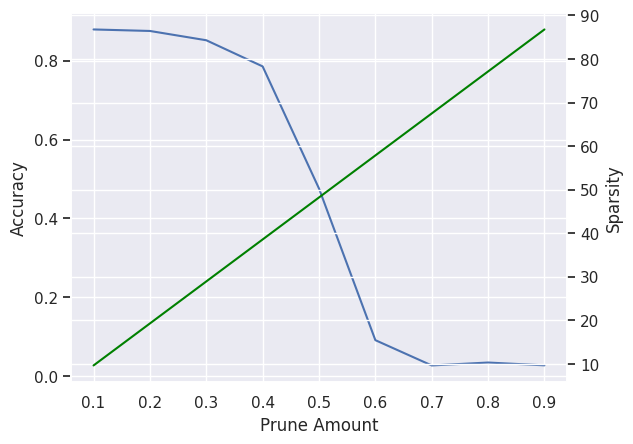

In [31]:
sns.set_style("darkgrid")
sns.lineplot(df, x="Prune Amount", y="Accuracy")
ax2 = plt.twinx()
sns.lineplot(df, x="Prune Amount", y="Sparsity", ax=ax2, color="green")
plt.show()